In [1]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
!git clone https://github.com/Aman-Yadav-PY/Vision-Transformer-Model.git
import os
os.chdir("Vision-Transformer-Model")

Cloning into 'Vision-Transformer-Model'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 153 (delta 79), reused 80 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (153/153), 3.80 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [3]:
import numpy as np
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.io import decode_image
from torchvision.datasets import Food101
from torchvision.transforms import Compose, v2
from torch.amp import GradScaler, autocast

from sklearn.model_selection import train_test_split
from modelpipe import HybridVitNet

from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [5]:
os.getcwd()

'/content/Vision-Transformer-Model'

In [6]:
root = os.getcwd()
ds_path = os.path.join(root, "dataset")
states_path = os.path.join(root, "checkpoint.pth")

generator = torch.Generator(device='cpu')

image_size = 512, 512
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Device: ", device)

Available Device:  cuda


In [7]:
def random_tt_split(dataset, factor):
    length= int(factor* len(dataset))
    remaining = len(dataset) - length
    datasetA, datasetB = random_split(dataset, [length, remaining], generator=generator)
    print("Splited Datset Lengths:", (len(datasetA), len(datasetB)))
    return datasetA,datasetB


def data_loader(dataset, shuffle=True, batch_size=batch_size, num_workers=2, prefetch_factor=8, pin_memory=True):
    return DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=2, prefetch_factor=2, pin_memory=True)

In [8]:
def get_subset(dataset, test_size, s_test_size=None):
    sample_indices, _ = train_test_split(range(len(dataset)),
                                         stratify=dataset._labels,
                                         test_size=test_size, random_state=42)

    sample_ds = Subset(dataset, sample_indices)
    print("Sample size: ", len(sample_ds))
    if s_test_size:
        subset_indx = np.array(sample_ds.dataset._labels)[sample_ds.indices]
        A_len, B_len =  train_test_split(range(len(sample_ds)), stratify=subset_indx, \
                                test_size=s_test_size, random_state=42)
        A = Subset(sample_ds, A_len)
        B = Subset(sample_ds, B_len)
        print(f"Subset samples size: {len(A)}, {len(B)}")

    print("Data Subset has been prepared.")
    return (A, B) if s_test_size else sample_ds


In [9]:
normalizer = v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1])

train_transform = v2.Compose([v2.Resize(image_size), v2.ToDtype(torch.float32, scale=True), normalizer])

test_transform = v2.Compose([v2.Resize(image_size), v2.ToDtype(torch.float32, scale=True), normalizer])

trainset = Food101(ds_path,split='train',download=True, transform=train_transform, loader=decode_image)
testset = Food101(ds_path, split='test', download=True, transform=test_transform, loader=decode_image)

100%|██████████| 5.00G/5.00G [03:36<00:00, 23.1MB/s]


In [10]:
print("Test & Validation sets")
testset, validset = get_subset(testset, 101, 0.2)
print("\nSmall sample sets")
s_trainset, s_testset = get_subset(trainset, 0.75, 0.2)

Test & Validation sets
Sample size:  25149
Subset samples size: 20119, 5030
Data Subset has been prepared.

Small sample sets
Sample size:  18937
Subset samples size: 15149, 3788
Data Subset has been prepared.


In [11]:
train_loader = data_loader(trainset)
valid_loader = data_loader(validset, shuffle=False)
test_loader = data_loader(testset, shuffle=False)

s_train_loader = data_loader(s_trainset)
s_test_loader = data_loader(s_testset, shuffle=False)

In [12]:
torch.cuda.get_device_name()

'Tesla T4'

In [13]:
CLASSES = 101

model = HybridVitNet(num_classes=CLASSES, num_layers=3).to(device)
model.initialize_weights()

total_params = 0

for params in model.parameters():
    if params.requires_grad:
        total_params += params.flatten().shape[0]

total_params = total_params/1_000_000
print(f"Trainable Params:{total_params:0.1f}M")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 153MB/s]


Trainable Params:23.7M


In [14]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
reduceLR = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
scaler = GradScaler()

In [15]:
def save_states(epoch, model, optimizer, scheduler, loss, path):
    state_dict_values = {
        "epoch":epoch,
        "model_state_dict":model.state_dict(),
        "optimizer_state_dict":optimizer.state_dict(),
        "loss":loss,
        "scheduler_state_dict":scheduler.state_dict()
    }
    torch.save(state_dict_values, path)

In [16]:
def validation_loss (model, test_data, loss_fn, device):
    model.eval()

    batch_loss = 0
    sample_count = 0
    with torch.no_grad():
        for x, y in tqdm(test_data):
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            loss =  loss_fn(out, y)
            batch_loss += loss.item()
            sample_count += 1

    return batch_loss/sample_count


def model_trainer(model, trainset, testset, epoch, loss_fn, optimizer_fn, scheduler, save_path=None, device=None, validator=None):
    Loss = []
    ValLoss = []
    best_loss = 1e2

    for ep in range(epoch):
        model.train()
        batch_loss = 0
        sample_count = 0
        for x, y in tqdm(trainset, desc=f"Epoch {ep+1}"):
            x = x.to(device)
            y = y.to(device)
            optimizer_fn.zero_grad()

            with autocast(device.type):
              out = model(x)
              loss = loss_fn(out, y)


            scaler.scale(loss).backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            scaler.step(optimizer_fn)
            scaler.update()

            sample_count+=1
            batch_loss += loss.detach().item()

        epoch_loss = batch_loss/sample_count
        Loss.append(epoch_loss)
        val_loss = validator(model, testset, loss_fn, device)
        ValLoss.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            save_states(ep, model, optimizer, scheduler, val_loss, save_path)


        if ep%2==0:
            print(f"loss: {epoch_loss:0.4f} | val_loss: {val_loss:0.4f} | learning_rate: {optimizer.state_dict()['param_groups'][0]["lr"]}")

    return {"loss":Loss, "val_loss":ValLoss}

In [17]:
device.type

'cuda'

In [18]:
EPOCH = 40
history = model_trainer(model, s_train_loader, s_test_loader, EPOCH, \
                        criterion, optimizer, reduceLR, save_path=states_path, validator=validation_loss, device=device)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


loss: 4.5959 | val_loss: 4.5509 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.4972 | val_loss: 4.4906 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.4746 | val_loss: 4.4786 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.4577 | val_loss: 4.4679 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


loss: 4.4356 | val_loss: 4.4439 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.4181 | val_loss: 4.4425 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.4088 | val_loss: 4.4328 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


loss: 4.4008 | val_loss: 4.4236 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3903 | val_loss: 4.4174 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.35s/it]


loss: 4.3793 | val_loss: 4.4112 | learning_rate: 0.0003


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3729 | val_loss: 4.4119 | learning_rate: 2.9999999999999997e-05


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3670 | val_loss: 4.4073 | learning_rate: 2.9999999999999997e-05


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3642 | val_loss: 4.4056 | learning_rate: 3e-06


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3651 | val_loss: 4.4078 | learning_rate: 3e-06


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3641 | val_loss: 4.4044 | learning_rate: 3.0000000000000004e-07


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3653 | val_loss: 4.4042 | learning_rate: 3.0000000000000004e-07


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3645 | val_loss: 4.4042 | learning_rate: 3.0000000000000004e-08


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3644 | val_loss: 4.4077 | learning_rate: 3.0000000000000004e-08


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3632 | val_loss: 4.4042 | learning_rate: 3.0000000000000004e-09


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


loss: 4.3646 | val_loss: 4.4053 | learning_rate: 3.0000000000000004e-09


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


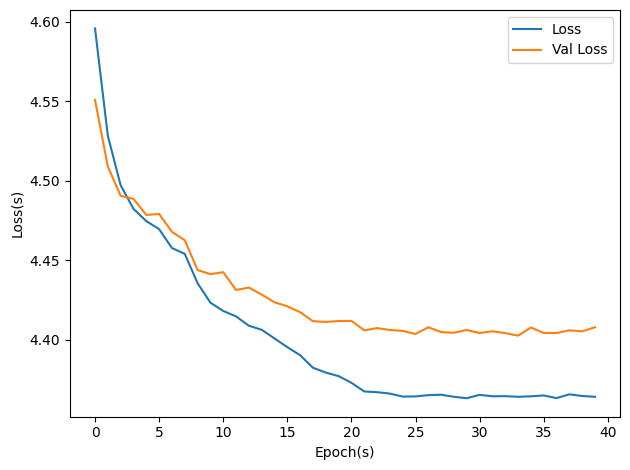

In [19]:
def loss_curve(losses):
    loss = losses['loss']
    val_loss = losses['val_loss']

    plt.plot(range(len(loss)), loss, label="Loss")
    plt.plot(range(len(val_loss)), val_loss, label="Val Loss")

    plt.xlabel("Epoch(s)")
    plt.ylabel("Loss(s)")


    plt.tight_layout()
    plt.legend()
    plt.show()

loss_curve(history)